
# Comparison between grid search and successive halving

This example compares the parameter search performed by
:class:`~sklearn.model_selection.HalvingGridSearchCV` and
:class:`~sklearn.model_selection.GridSearchCV`.


### HalvingGridSearchCV

#### Overview

`HalvingGridSearchCV` is an iterative search algorithm that finds the best hyperparameters for a model by progressively narrowing down the search space. It is a more efficient version of `GridSearchCV` that uses successive halving, a resource allocation strategy that allocates more resources to the most promising candidates. This approach reduces computation time and can lead to faster convergence to the optimal hyperparameters.

#### How It Works

1. **Initial Setup**:
   - Define the parameter grid and the initial amount of resources allocated to each candidate.
   - Resources can refer to the number of samples, iterations, or any measure that increases the computation.

2. **First Iteration**:
   - Train all candidate models with the initial resource allocation.
   - Evaluate each model's performance.

3. **Successive Halving**:
   - Rank the models based on their performance.
   - Discard the worst-performing half of the models.
   - Double the resources for the remaining models.

4. **Repeat**:
   - Continue the process until the maximum amount of resources is allocated or only one model remains.

#### Mathematical Formulation

Let:
- $n$ be the number of candidates.
- $r_0$ be the initial resource allocation.
- $\eta$ be the reduction factor (commonly set to 2).

The process can be described as follows:

1. **Initial Resource Allocation**:
   - Allocate $r_0$ resources to each of the $n$ candidates.

2. **First Iteration**:
   - Evaluate all $n$ candidates.
   - Keep the top $\left\lceil \frac{n}{\eta} \right\rceil$ candidates.
   - Allocate $\eta \times r_0$ resources to each remaining candidate.

3. **Subsequent Iterations**:
   - For each iteration $i$:
     - Evaluate the remaining candidates.
     - Keep the top $\left\lceil \frac{n}{\eta^i} \right\rceil$ candidates.
     - Allocate $\eta^i \times r_0$ resources to each remaining candidate.

4. **Termination**:
   - The process continues until the maximum resources are allocated or only one candidate remains.

#### Differences from Classic GridSearchCV

- **Efficiency**:
  - `GridSearchCV` evaluates all combinations of hyperparameters with the same amount of resources, leading to high computational cost.
  - `HalvingGridSearchCV` progressively allocates more resources to the most promising candidates, reducing overall computation time.

- **Resource Allocation**:
  - `GridSearchCV` uses a fixed resource allocation for all candidates.
  - `HalvingGridSearchCV` dynamically increases the resources for better-performing candidates through successive halving.

- **Speed**:
  - `HalvingGridSearchCV` can converge to the optimal hyperparameters faster than `GridSearchCV` by focusing resources on the most promising candidates early in the process.

### Conclusion

`HalvingGridSearchCV` is a more efficient alternative to `GridSearchCV`, employing successive halving to allocate resources dynamically and focus on the most promising hyperparameter combinations. This approach can significantly reduce computation time and improve the speed of hyperparameter optimization, making it a valuable tool for large-scale machine learning tasks.


In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.svm import SVC

We first define the parameter space for an :class:`~sklearn.svm.SVC`
estimator, and compute the time required to train a
:class:`~sklearn.model_selection.HalvingGridSearchCV` instance, as well as a
:class:`~sklearn.model_selection.GridSearchCV` instance.



In [2]:
rng = np.random.RandomState(0)
X, y = datasets.make_classification(n_samples=1000, random_state=rng)

gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {"gamma": gammas, "C": Cs}

clf = SVC(random_state=rng)

tic = time()
gsh = HalvingGridSearchCV(
    estimator=clf, param_grid=param_grid, factor=2, random_state=rng
)
gsh.fit(X, y)
gsh_time = time() - tic

tic = time()
gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(X, y)
gs_time = time() - tic

We now plot heatmaps for both search estimators.



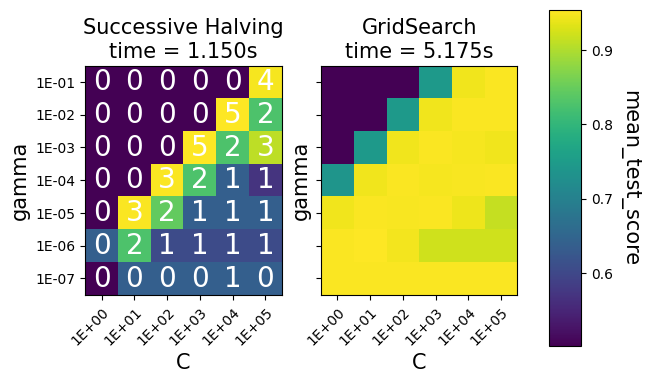

In [3]:
def make_heatmap(ax, gs, is_sh=False, make_cbar=False):
    """Helper to make a heatmap."""
    results = pd.DataFrame(gs.cv_results_)
    results[["param_C", "param_gamma"]] = results[["param_C", "param_gamma"]].astype(
        np.float64
    )
    if is_sh:
        # SH dataframe: get mean_test_score values for the highest iter
        scores_matrix = results.sort_values("iter").pivot_table(
            index="param_gamma",
            columns="param_C",
            values="mean_test_score",
            aggfunc="last",
        )
    else:
        scores_matrix = results.pivot(
            index="param_gamma", columns="param_C", values="mean_test_score"
        )

    im = ax.imshow(scores_matrix)

    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels(["{:.0E}".format(x) for x in Cs])
    ax.set_xlabel("C", fontsize=15)

    ax.set_yticks(np.arange(len(gammas)))
    ax.set_yticklabels(["{:.0E}".format(x) for x in gammas])
    ax.set_ylabel("gamma", fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    if is_sh:
        iterations = results.pivot_table(
            index="param_gamma", columns="param_C", values="iter", aggfunc="max"
        ).values
        for i in range(len(gammas)):
            for j in range(len(Cs)):
                ax.text(
                    j,
                    i,
                    iterations[i, j],
                    ha="center",
                    va="center",
                    color="w",
                    fontsize=20,
                )

    if make_cbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel("mean_test_score", rotation=-90, va="bottom", fontsize=15)


fig, axes = plt.subplots(ncols=2, sharey=True)
ax1, ax2 = axes

make_heatmap(ax1, gsh, is_sh=True)
make_heatmap(ax2, gs, make_cbar=True)

ax1.set_title("Successive Halving\ntime = {:.3f}s".format(gsh_time), fontsize=15)
ax2.set_title("GridSearch\ntime = {:.3f}s".format(gs_time), fontsize=15)

plt.show()

The heatmaps show the mean test score of the parameter combinations for an
:class:`~sklearn.svm.SVC` instance. The
:class:`~sklearn.model_selection.HalvingGridSearchCV` also shows the
iteration at which the combinations where last used. The combinations marked
as ``0`` were only evaluated at the first iteration, while the ones with
``5`` are the parameter combinations that are considered the best ones.

We can see that the :class:`~sklearn.model_selection.HalvingGridSearchCV`
class is able to find parameter combinations that are just as accurate as
:class:`~sklearn.model_selection.GridSearchCV`, in much less time.

